In [1]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

### train dataset

In [2]:
train = pd.read_csv('Datasets/train_dataset.csv')
train['orderDate'] = pd.to_datetime(train['orderDate'], format = '%Y-%m-%d')
train['deliveryDate'] = pd.to_datetime(train['deliveryDate'], format = '%Y-%m-%d')
train['dateOfBirth'] = pd.to_datetime(train['dateOfBirth'], format = "%Y-%m-%d")
train['creationDate'] = pd.to_datetime(train['creationDate'], format = "%Y-%m-%d")
train.head()

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment
0,1,2012-04-01,2012-04-03,186,m,denim,25,69.90,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,0
1,2,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1
2,3,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1
3,4,2012-04-02,NaT,22,m,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0
4,5,2012-04-02,1990-12-31,151,39,black,53,29.90,825,Mrs,1964-07-11,Rhineland-Palatinate,2011-02-16,0


In [3]:
train.shape

(481092, 14)

### test dataset

In [4]:
test = pd.read_csv('Datasets/test_dataset.csv')
test['orderDate'] = pd.to_datetime(test['orderDate'], format = '%Y-%m-%d')
test['deliveryDate'] = pd.to_datetime(test['deliveryDate'], format = '%Y-%m-%d')
test['dateOfBirth'] = pd.to_datetime(test['dateOfBirth'], format = "%Y-%m-%d")
test['creationDate'] = pd.to_datetime(test['creationDate'], format = "%Y-%m-%d")
test.head()

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate
0,1,2013-04-01,2013-04-03,2347,43,magenta,1,89.9,12489,Mrs,1963-04-26,Hesse,2012-04-23
1,2,2013-04-01,2013-04-03,2741,43,grey,1,99.9,12489,Mrs,1963-04-26,Hesse,2012-04-23
2,3,2013-04-01,2013-04-03,2514,9,ecru,19,79.9,12489,Mrs,1963-04-26,Hesse,2012-04-23
3,4,2013-04-01,2013-05-06,2347,42,brown,1,89.9,12489,Mrs,1963-04-26,Hesse,2012-04-23
4,5,2013-04-01,NaT,2690,43,grey,1,119.9,12489,Mrs,1963-04-26,Hesse,2012-04-23


In [5]:
test.shape

(50078, 13)

## Engineering days_to_delivery variable

In [6]:
# Getting the number of days to delivery
train['days_to_delivery'] = (train['deliveryDate'] - train['orderDate']).dt.days

## test
test['days_to_delivery'] = (test['deliveryDate'] - test['orderDate']).dt.days
train['days_to_delivery']

0            2.0
1            2.0
2            2.0
3            NaN
4        -7763.0
           ...  
481087       9.0
481088       2.0
481089   -8126.0
481090   -8126.0
481091   -8126.0
Name: days_to_delivery, Length: 481092, dtype: float64

In [7]:
# Changing negative days to delivery to 0
wrong_delivery_date = train
wrong_delivery_date['days_to_delivery'] = np.where(train['days_to_delivery'] < 0, 0,train['days_to_delivery'])
wrong_delivery_date['days_to_delivery']

0         2.0
1         2.0
2         2.0
3         NaN
4         0.0
         ... 
481087    9.0
481088    2.0
481089    0.0
481090    0.0
481091    0.0
Name: days_to_delivery, Length: 481092, dtype: float64

In [8]:
# Now, there is no negative numbers. Let's then find the average of days to delivey
mean = round(np.mean(wrong_delivery_date['days_to_delivery']))
mean

11

In [9]:
# assuming average to the transactions with nevagative days to delivery
train['days_to_delivery'] = np.where(train['days_to_delivery'] == 0, mean, train['days_to_delivery'])

## test
test['days_to_delivery'] = np.where(test['days_to_delivery'] == 0, mean, test['days_to_delivery'])
train.head()

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment,days_to_delivery
0,1,2012-04-01,2012-04-03,186,m,denim,25,69.90,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,0,2.0
1,2,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1,2.0
2,3,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1,2.0
3,4,2012-04-02,NaT,22,m,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0,NaN
4,5,2012-04-02,1990-12-31,151,39,black,53,29.90,825,Mrs,1964-07-11,Rhineland-Palatinate,2011-02-16,0,11.0


In [10]:
# assuming average to the transactions with NaN days to delivery
train.loc[np.isnan(train['days_to_delivery']), 'days_to_delivery'] = round(np.mean(train['days_to_delivery']))

## test
test.loc[np.isnan(test['days_to_delivery']), 'days_to_delivery'] = round(np.mean(test['days_to_delivery']))
train.head()

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment,days_to_delivery
0,1,2012-04-01,2012-04-03,186,m,denim,25,69.90,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,0,2.0
1,2,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1,2.0
2,3,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1,2.0
3,4,2012-04-02,NaT,22,m,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0,11.0
4,5,2012-04-02,1990-12-31,151,39,black,53,29.90,825,Mrs,1964-07-11,Rhineland-Palatinate,2011-02-16,0,11.0


## Engineering age in years variable

In [11]:
## train
train['Customer_age'] = (train['orderDate'] - train['dateOfBirth']).dt.days
train['Customer_age'] = round(train['Customer_age'] / 365)

## test
test['Customer_age'] = (test['orderDate'] - test['dateOfBirth']).dt.days
test['Customer_age'] = round(test['Customer_age'] / 365)

train['Customer_age']

0         47.0
1         47.0
2         47.0
3         52.0
4         48.0
          ... 
481087    50.0
481088     NaN
481089    40.0
481090    40.0
481091    40.0
Name: Customer_age, Length: 481092, dtype: float64

### Removing nan values

In [12]:
## Train
train.loc[np.isnan(train['Customer_age']), 'Customer_age'] = round(np.mean(train['Customer_age']))

## test
test.loc[np.isnan(test['Customer_age']), 'Customer_age'] = round(np.mean(test['Customer_age']))

train['Customer_age']

0         47.0
1         47.0
2         47.0
3         52.0
4         48.0
          ... 
481087    50.0
481088    49.0
481089    40.0
481090    40.0
481091    40.0
Name: Customer_age, Length: 481092, dtype: float64

### manufacturerID Ratio

In [13]:
# Creating table with the number of returns and no returns 
manufacturer_return = pd.DataFrame(pd.crosstab(train['manufacturerID'], train['returnShipment']))
manufacturer_return.columns = ['No_Return', 'Return']

#omputing the total sales number
manufacturer_return['Tot_Sales'] = manufacturer_return['No_Return'] + manufacturer_return['Return']

# Temporary variable to store Tot_Sales
first_column = manufacturer_return.pop('Tot_Sales')

# Tot_Sales to the first column
manufacturer_return.insert(0, 'Tot_Sales', first_column)

# Computing row-wise percentage
manufacturer_return['No_Return_Pct'] = round(manufacturer_return['No_Return'] / manufacturer_return['Tot_Sales'], 2)
manufacturer_return['Return_Pct'] = round(manufacturer_return['Return'] / manufacturer_return['Tot_Sales'], 2)

# Sorting based on the return pecentage
manufacturer_return = manufacturer_return.sort_values(by = 'Return_Pct', ascending = False)
manufacturer_return['manufacturerID'] = manufacturer_return.index
manufacturer_return = manufacturer_return.reset_index(drop = True)

# Selecting more than 100 orders
manufacturer_return = manufacturer_return[manufacturer_return['Return_Pct'] > 0.55]
manufacturer_return

,Tot_Sales,No_Return,Return,No_Return_Pct,Return_Pct,manufacturerID
0,2,0,2,0.00,1.00,93
1,2,0,2,0.00,1.00,143
2,4,0,4,0.00,1.00,105
3,141,23,118,0.16,0.84,96
4,187,35,152,0.19,0.81,101
5,197,39,158,0.20,0.80,89
6,217,67,150,0.31,0.69,100
7,304,94,210,0.31,0.69,152
8,34,11,23,0.32,0.68,88
9,9,3,6,0.33,0.67,103


### Checking how many items were sold by manufacturers with return percentage higher than our benchmark of 55%

In [14]:
manufacturer_return['Tot_Sales'].sum()

82001

### Flagging all manufacturers' id with return percentage higher than 55%

In [15]:
## Train
train['manufacturer_highest_return_rate'] = np.where(np.isin(train['manufacturerID'], manufacturer_return['manufacturerID'].values), 1, 0, )

## test 
test['manufacturer_highest_return_rate'] = np.where(np.isin(test['manufacturerID'], manufacturer_return['manufacturerID'].values), 1, 0, )

train['manufacturer_highest_return_rate'].value_counts()

0    399091
1     82001
Name: manufacturer_highest_return_rate, dtype: int64

### itemID Ratio

In [16]:
# Creating table with the number of returns and no returns 
item_return = pd.DataFrame(pd.crosstab(train['itemID'], train['returnShipment']))
item_return.columns = ['No_Return', 'Return']

# Computing the item total sales
item_return['Tot_Sales'] = item_return['No_Return'] + item_return['Return']

# Temporary variable to store Tot_Sales variable
first_column = item_return.pop('Tot_Sales')
  
# Tot_Sales to first position
item_return.insert(0, 'Tot_Sales', first_column)

# Computing the row-wise percentage
item_return['No_Return_Pct'] = round(item_return['No_Return'] / item_return['Tot_Sales'], 2)
item_return['Return_Pct'] = round(item_return['Return'] / item_return['Tot_Sales'], 2)

# Sorting based on return percentage
item_return = item_return.sort_values(by = 'Return_Pct', ascending = False)
item_return['itemID'] = item_return.index
item_return = item_return.reset_index(drop = True)
## item_return

# Selecting items with more than 100 orders
item_return = item_return[item_return['Return_Pct'] > 0.55]
item_return

,Tot_Sales,No_Return,Return,No_Return_Pct,Return_Pct,itemID
0,1,0,1,0.00,1.00,602
1,1,0,1,0.00,1.00,986
2,2,0,2,0.00,1.00,743
3,5,0,5,0.00,1.00,2997
4,1,0,1,0.00,1.00,742
...,...,...,...,...,...,...
992,149,65,84,0.44,0.56,2526
993,9,4,5,0.44,0.56,916
994,129,57,72,0.44,0.56,2773
995,162,72,90,0.44,0.56,2609


### Checking how many items were sold with return percentage higher than our benchmark of 55%

In [17]:
item_return['Tot_Sales'].sum()

159275

### Flagging all items' id with return percentage higher than 55%

In [18]:
## Train
train['item_highest_return_rate'] = np.where(np.isin(train['itemID'], item_return['itemID'].values), 1, 0, )

## Test
test['item_highest_return_rate'] = np.where(np.isin(test['itemID'], item_return['itemID'].values), 1, 0, )

train['item_highest_return_rate'].value_counts()

0    321817
1    159275
Name: item_highest_return_rate, dtype: int64

### Flagging all observations containing itemID & manufacturerID with return percentage >55%

In [19]:
## train
train['feature_100'] = np.where(np.isin(train['itemID'], item_return['itemID'].values) & (np.isin(train['manufacturerID'], manufacturer_return['manufacturerID'].values)), 1, 0, )

## test
test['feature_100'] = np.where(np.isin(test['itemID'], item_return['itemID'].values) & (np.isin(test['manufacturerID'], manufacturer_return['manufacturerID'].values)), 1, 0, )

train['feature_100'].value_counts()

0    421092
1     60000
Name: feature_100, dtype: int64

### Size Ratio

In [20]:
# Creating table with the number of returns and no returns 
size_return = pd.DataFrame(pd.crosstab(train['size'], train['returnShipment']))
size_return.columns = ['No_Return', 'Return']

# Computing the total sales number
size_return['Tot_Sales'] = size_return['No_Return'] + size_return['Return']

# Temporary variable to store Tot_Sales
first_column = size_return.pop('Tot_Sales')

# Tot_Sales to the first column
size_return.insert(0, 'Tot_Sales', first_column)

# Computing row-wise percentage
size_return['No_Return_Pct'] = round(size_return['No_Return'] / size_return['Tot_Sales'], 2)
size_return['Return_Pct'] = round(size_return['Return'] / size_return['Tot_Sales'], 2)

# Sorting based on the return pecentage
size_return = size_return.sort_values(by = 'Return_Pct', ascending = False)
size_return['size'] = size_return.index
size_return = size_return.reset_index(drop = True)

# Selecting more than 100 orders
size_return = size_return[size_return['Return_Pct'] > 0.55]
size_return

,Tot_Sales,No_Return,Return,No_Return_Pct,Return_Pct,size
0,3,0,3,0.00,1.00,2+
1,4,0,4,0.00,1.00,4034
2,1,0,1,0.00,1.00,110
3,3,1,2,0.33,0.67,122
4,9,3,6,0.33,0.67,3334
5,3,1,2,0.33,0.67,95
6,31,11,20,0.35,0.65,96
7,14,5,9,0.36,0.64,58
8,18,7,11,0.39,0.61,4032
9,425,177,248,0.42,0.58,23


### Checking how many items in each size were sold with return percentage higher than our benchmark of 55%

In [21]:
size_return['Tot_Sales'].sum()

18626

### Flagging all items' id with sizes that have return percentage higher than 55%

In [22]:
## train
train['size_highest_return_rate'] = np.where(np.isin(train['size'], size_return['size'].values), 1, 0, )

## Test
test['size_highest_return_rate'] = np.where(np.isin(test['size'], size_return['size'].values), 1, 0, )

train['size_highest_return_rate'].value_counts()

0    462466
1     18626
Name: size_highest_return_rate, dtype: int64

In [23]:
types_of_size = train['size'].unique()
print(types_of_size.tolist())

['m', '9+', '39', 'xxl', '37', '43', '38', 'l', 'xl', '42', '41', 'unsized', 's', '10+', '40', '36', '152', '35', '34', '8+', '9', '46', '6', '10', '25', '20', '5', '42+', '44', '4+', '8', '3', '6+', '48', '7+', '50', '22', '12', '45', '7', '24', '36+', '39+', '27', '32', '11', '26', '40+', '19', '21', '5+', '116', '2', '28', '38+', '11+', '37+', '164', '4', '33', '29', '30', '18', '41+', '1', '47', '31', '104', '128', '95', '3+', '140', '23', '13', '3332', 'S', '44+', 'xxxl', '54', '52', '3432', '43+', '3434', '49', '84', '56', '14', '13+', '76', '90', '85', '176', '88', '45+', 'L', '46+', '80', '3632', '3832', '3634', '4032', 'xs', '2+', '100', '3132', '58', '4034', '105', '3834', '12+', '2932', 'M', '110', '122', 'XXL', 'XL', 'XXXL', '4232', 'XS', '92', '96', '3334']


In [24]:
## train
train['clothes'] = np.where((train['size'] == 'm') | (train['size'] == 'xxl') | 
                            (train['size'] == 'l') | (train['size'] == 'xl') |
                            (train['size'] == 's') | (train['size'] == 'S') |
                            (train['size'] == 'xxxl') | (train['size'] == 'L'), 1, 0)

## Test
test['clothes'] = np.where((test['size'] == 'm') | (test['size'] == 'xxl') | 
                            (test['size'] == 'l') | (test['size'] == 'xl') |
                            (test['size'] == 's') | (test['size'] == 'S') |
                            (test['size'] == 'xxxl') | (test['size'] == 'L'), 1, 0)
train[train['size'] == '44']

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,...,state,creationDate,returnShipment,days_to_delivery,Customer_age,manufacturer_highest_return_rate,item_highest_return_rate,feature_100,size_highest_return_rate,clothes
132,133,2012-04-01,2012-04-04,140,44,black,6,69.90,1114,Mrs,...,Bavaria,2012-04-01,0,3.0,54.0,0,1,0,0,0
217,218,2012-04-02,NaT,83,44,black,39,99.95,1153,Mrs,...,Lower Saxony,2012-03-22,0,11.0,61.0,0,0,0,0,0
285,286,2012-04-01,2012-04-04,320,44,blue,25,69.90,1185,Mrs,...,Saxony,2011-02-16,1,3.0,61.0,1,1,1,0,0
632,633,2012-04-01,2012-04-04,140,44,black,6,69.90,1350,Mrs,...,Bavaria,2011-02-16,1,3.0,46.0,0,1,0,0,0
671,672,2012-04-01,2012-04-04,574,44,brown,11,29.90,1366,Mrs,...,Lower Saxony,2011-02-16,0,3.0,51.0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480183,480184,2013-03-31,2013-05-01,2547,44,ocher,6,79.90,86428,Mrs,...,Berlin,2011-02-16,1,31.0,47.0,0,0,0,0,0
480723,480724,2013-03-31,2013-04-03,1544,44,grey,74,35.90,86515,Mrs,...,Lower Saxony,2013-03-31,1,3.0,49.0,0,0,0,0,0
480738,480739,2013-03-31,2013-04-02,2422,44,blue,14,69.90,23750,Mrs,...,North Rhine-Westphalia,2012-05-27,1,2.0,47.0,0,1,0,0,0
480752,480753,2013-03-31,2013-06-17,2378,44,grey,72,129.90,30564,Mrs,...,Baden-Wuerttemberg,2012-06-21,1,78.0,50.0,0,1,0,0,0


### State Ratio

In [25]:
# Creating table with the number of returns and no returns 
state_return = pd.DataFrame(pd.crosstab(train['state'], train['returnShipment']))
state_return.columns = ['No_Return', 'Return']

#omputing the total sales number
state_return['Tot_Sales'] = state_return['No_Return'] + state_return['Return']

# Temporary variable to store Tot_Sales
first_column = state_return.pop('Tot_Sales')

# Tot_Sales to the first column
state_return.insert(0, 'Tot_Sales', first_column)

# Computing row-wise percentage
state_return['No_Return_Pct'] = round(state_return['No_Return'] / state_return['Tot_Sales'], 2)
state_return['Return_Pct'] = round(state_return['Return'] / state_return['Tot_Sales'], 2)

# Sorting based on the return pecentage
state_return = state_return.sort_values(by = 'Return_Pct', ascending = False)
state_return['state'] = state_return.index
state_return = state_return.reset_index(drop = True)

# Selecting more than 100 orders
state_return = state_return[state_return['Return_Pct'] > 0.5]
state_return

,Tot_Sales,No_Return,Return,No_Return_Pct,Return_Pct,state
0,14869,7317,7552,0.49,0.51,Saxony
1,5587,2749,2838,0.49,0.51,Saxony-Anhalt


### Checking how many items were sold in each state with return percentage higher than our benchmark of 55%

In [26]:
state_return['Tot_Sales'].sum()

20456

### Flagging all states that have return percentage higher than 50%

In [27]:
## Train
train['state_highest_return_rate'] = np.where(np.isin(train['state'], state_return['state'].values), 1, 0, )

## Test
test['state_highest_return_rate'] = np.where(np.isin(test['state'], state_return['state'].values), 1, 0, )

train['state_highest_return_rate'].value_counts()

0    460636
1     20456
Name: state_highest_return_rate, dtype: int64

### salutation

In [28]:
## Train
train['salutation_highest_return_rate'] = np.where(train['salutation'] == 'Mrs', 1, 0)

## Test
test['salutation_highest_return_rate'] = np.where(test['salutation'] == 'Mrs', 1, 0)

train['salutation_highest_return_rate'].value_counts()

1    461769
0     19323
Name: salutation_highest_return_rate, dtype: int64

### Getting the average price of each item

In [29]:
## train
avg_price_p_item = pd.DataFrame(train.groupby(by=['itemID'])['price'].mean())
avg_price_p_item['itemID'] = avg_price_p_item.index
avg_price_p_item = avg_price_p_item.reset_index(drop = True)
avg_price_p_item = avg_price_p_item.rename(columns = {'price': "Item_Average_Price"})
avg_price_p_item['Item_Average_Price'] = round(avg_price_p_item['Item_Average_Price'], 2)
avg_price_p_item.head()

,Item_Average_Price,itemID
0,111.65,1
1,30.45,2
2,23.10,3
3,89.85,4
4,52.66,5


In [30]:
## Test
avg_price_p_item_test = pd.DataFrame(test.groupby(by=['itemID'])['price'].mean())
avg_price_p_item_test['itemID'] = avg_price_p_item_test.index
avg_price_p_item_test = avg_price_p_item_test.reset_index(drop = True)
avg_price_p_item_test = avg_price_p_item_test.rename(columns = {'price': "Item_Average_Price"})
avg_price_p_item_test['Item_Average_Price'] = round(avg_price_p_item_test['Item_Average_Price'], 2)
avg_price_p_item_test.head()

,Item_Average_Price,itemID
0,69.9,1
1,19.9,3
2,89.9,4
3,39.9,5
4,14.9,8


### Adding the average price item column to the dataset

In [31]:
## Train
train = pd.merge(train, avg_price_p_item, on = 'itemID', how = 'left')

## Test
test = pd.merge(test, avg_price_p_item_test, on = 'itemID', how = 'left')
train.head()

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,...,days_to_delivery,Customer_age,manufacturer_highest_return_rate,item_highest_return_rate,feature_100,size_highest_return_rate,clothes,state_highest_return_rate,salutation_highest_return_rate,Item_Average_Price
0,1,2012-04-01,2012-04-03,186,m,denim,25,69.90,794,Mrs,...,2.0,47.0,1,1,1,0,1,0,1,69.47
1,2,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,Mrs,...,2.0,47.0,1,1,1,0,0,0,1,57.97
2,3,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,Mrs,...,2.0,47.0,1,1,1,0,0,0,1,57.97
3,4,2012-04-02,NaT,22,m,green,14,39.90,808,Mrs,...,11.0,52.0,0,0,0,0,1,1,1,31.10
4,5,2012-04-02,1990-12-31,151,39,black,53,29.90,825,Mrs,...,11.0,48.0,1,1,1,0,0,0,1,27.65


### Flagging all items sold for 40% more expensive than the item id average price. 

In [32]:
## Train
train['price_higher_average'] = train['price']/train['Item_Average_Price']
train['price_higher_average'] = np.where(train['price_higher_average'] > 1.4, 1, 0)

## Test
test['price_higher_average'] = test['price']/test['Item_Average_Price']
test['price_higher_average'] = np.where(test['price_higher_average'] > 1.4, 1, 0)

X = train[train['price_higher_average'] == 1]
X.shape

(12152, 25)

In [33]:
round(X['returnShipment'].value_counts() / X.shape[0], 2)

1    0.56
0    0.44
Name: returnShipment, dtype: float64

### Breaking the categorical salutation variable into dummies variables.

In [34]:
# Dummies of Salutation
## train
train = pd.concat([train, pd.get_dummies(train['salutation'])], axis = 1)

## Test
test = pd.concat([test, pd.get_dummies(test['salutation'])], axis = 1)

train.head()

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,...,clothes,state_highest_return_rate,salutation_highest_return_rate,Item_Average_Price,price_higher_average,Company,Family,Mr,Mrs,not reported
0,1,2012-04-01,2012-04-03,186,m,denim,25,69.90,794,Mrs,...,1,0,1,69.47,0,0,0,0,1,0
1,2,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,Mrs,...,0,0,1,57.97,0,0,0,0,1,0
2,3,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,Mrs,...,0,0,1,57.97,0,0,0,0,1,0
3,4,2012-04-02,NaT,22,m,green,14,39.90,808,Mrs,...,1,1,1,31.10,0,0,0,0,1,0
4,5,2012-04-02,1990-12-31,151,39,black,53,29.90,825,Mrs,...,0,0,1,27.65,0,0,0,0,1,0


In [35]:
train['salutation'].value_counts()

Mrs             461769
Mr               16720
Family            1891
Company            361
not reported       351
Name: salutation, dtype: int64

In [36]:
## Train
train['salutation_numb'] = np.where(train['salutation'] == 'Mrs', 1,
                            np.where(train['salutation'] == 'Mr', 2,
                            np.where(train['salutation'] == 'Family', 3, 4)))
train.head()

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,...,state_highest_return_rate,salutation_highest_return_rate,Item_Average_Price,price_higher_average,Company,Family,Mr,Mrs,not reported,salutation_numb
0,1,2012-04-01,2012-04-03,186,m,denim,25,69.90,794,Mrs,...,0,1,69.47,0,0,0,0,1,0,1
1,2,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,Mrs,...,0,1,57.97,0,0,0,0,1,0,1
2,3,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,Mrs,...,0,1,57.97,0,0,0,0,1,0,1
3,4,2012-04-02,NaT,22,m,green,14,39.90,808,Mrs,...,1,1,31.10,0,0,0,0,1,0,1
4,5,2012-04-02,1990-12-31,151,39,black,53,29.90,825,Mrs,...,0,1,27.65,0,0,0,0,1,0,1


In [37]:
# test
test['salutation_numb'] = np.where(test['salutation'] == 'Mrs', 1,
                            np.where(test['salutation'] == 'Mr', 2,
                            np.where(test['salutation'] == 'Family', 3, 4)))
test.head()

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,...,state_highest_return_rate,salutation_highest_return_rate,Item_Average_Price,price_higher_average,Company,Family,Mr,Mrs,not reported,salutation_numb
0,1,2013-04-01,2013-04-03,2347,43,magenta,1,89.9,12489,Mrs,...,0,1,89.9,0,0,0,0,1,0,1
1,2,2013-04-01,2013-04-03,2741,43,grey,1,99.9,12489,Mrs,...,0,1,99.9,0,0,0,0,1,0,1
2,3,2013-04-01,2013-04-03,2514,9,ecru,19,79.9,12489,Mrs,...,0,1,79.9,0,0,0,0,1,0,1
3,4,2013-04-01,2013-05-06,2347,42,brown,1,89.9,12489,Mrs,...,0,1,89.9,0,0,0,0,1,0,1
4,5,2013-04-01,NaT,2690,43,grey,1,119.9,12489,Mrs,...,0,1,119.9,0,0,0,0,1,0,1


### Oscar's Features

In [38]:
## Train
train['feature_1'] = np.where((train['manufacturerID'] == 113) & (train['salutation'] == 'Mrs'), 1, 0)
train['feature_2'] = np.where((train['manufacturerID'] == 20) & (train['salutation'] == 'Mrs'), 1, 0)
train['feature_3'] = np.where((train['manufacturerID'] == 49) & (train['salutation'] == 'Mrs'), 1, 0)
train['feature_4'] = np.where((train['manufacturerID'] == 21) & (train['salutation'] == 'Mrs'), 1, 0)
train['feature_5'] = np.where((train['manufacturerID'] == 24) & (train['salutation'] == 'Mrs'), 1, 0)
train['feature_6'] = np.where((train['manufacturerID'] == 54) & (train['salutation'] == 'Mrs'), 1, 0)
train['feature_7'] = np.where((train['manufacturerID'] == 25) & (train['salutation'] == 'Mrs'), 1, 0)
train['feature_8'] = np.where((train['manufacturerID'] == 45) & (train['salutation'] == 'Mrs'), 1, 0)
train['feature_9'] = np.where((train['manufacturerID'] == 18) & (train['salutation'] == 'Mrs'), 1, 0)
train['feature_10'] = np.where((train['manufacturerID'] == 97) & (train['salutation'] == 'Mrs'), 1, 0)
train['feature_11'] = np.where((train['manufacturerID'] == 55) & (train['salutation'] == 'Mrs'), 1, 0)
train['feature_12'] = np.where((train['manufacturerID'] == 26) & (train['salutation'] == 'Mrs'), 1, 0)
train['feature_13'] = np.where((train['manufacturerID'] == 53) & (train['salutation'] == 'Mrs'), 1, 0)
train['feature_14'] = np.where((train['manufacturerID'] == 56) & (train['salutation'] == 'Mrs'), 1, 0)
train['feature_15'] = np.where((train['manufacturerID'] == 44) & (train['salutation'] == 'Mrs'), 1, 0)
train['feature_16'] = np.where((train['manufacturerID'] == 75) & (train['salutation'] == 'Mrs'), 1, 0)
train['feature_17'] = np.where((train['manufacturerID'] == 64) & (train['salutation'] == 'Mrs'), 1, 0)
train['feature_18'] = np.where((train['manufacturerID'] == 16) & (train['salutation'] == 'Mrs'), 1, 0)

In [39]:
## test
test['feature_1'] = np.where((test['manufacturerID'] == 113) & (test['salutation'] == 'Mrs'), 1, 0)
test['feature_2'] = np.where((test['manufacturerID'] == 20) & (test['salutation'] == 'Mrs'), 1, 0)
test['feature_3'] = np.where((test['manufacturerID'] == 49) & (test['salutation'] == 'Mrs'), 1, 0)
test['feature_4'] = np.where((test['manufacturerID'] == 21) & (test['salutation'] == 'Mrs'), 1, 0)
test['feature_5'] = np.where((test['manufacturerID'] == 24) & (test['salutation'] == 'Mrs'), 1, 0)
test['feature_6'] = np.where((test['manufacturerID'] == 54) & (test['salutation'] == 'Mrs'), 1, 0)
test['feature_7'] = np.where((test['manufacturerID'] == 25) & (test['salutation'] == 'Mrs'), 1, 0)
test['feature_8'] = np.where((test['manufacturerID'] == 45) & (test['salutation'] == 'Mrs'), 1, 0)
test['feature_9'] = np.where((test['manufacturerID'] == 18) & (test['salutation'] == 'Mrs'), 1, 0)
test['feature_10'] = np.where((test['manufacturerID'] == 97) & (test['salutation'] == 'Mrs'), 1, 0)
test['feature_11'] = np.where((test['manufacturerID'] == 55) & (test['salutation'] == 'Mrs'), 1, 0)
test['feature_12'] = np.where((test['manufacturerID'] == 26) & (test['salutation'] == 'Mrs'), 1, 0)
test['feature_13'] = np.where((test['manufacturerID'] == 53) & (test['salutation'] == 'Mrs'), 1, 0)
test['feature_14'] = np.where((test['manufacturerID'] == 56) & (test['salutation'] == 'Mrs'), 1, 0)
test['feature_15'] = np.where((test['manufacturerID'] == 44) & (test['salutation'] == 'Mrs'), 1, 0)
test['feature_16'] = np.where((test['manufacturerID'] == 75) & (test['salutation'] == 'Mrs'), 1, 0)
test['feature_17'] = np.where((test['manufacturerID'] == 64) & (test['salutation'] == 'Mrs'), 1, 0)
test['feature_18'] = np.where((test['manufacturerID'] == 16) & (test['salutation'] == 'Mrs'), 1, 0)

In [40]:
train.shape

(481092, 49)

In [41]:
test.shape

(50078, 48)

[Text(697.5, 951.3000000000001, 'item_highest_return_rate <= 0.5\ngini = 0.499\nsamples = 384873\nvalue = [199200, 185673]'),
 Text(348.75, 679.5, 'days_to_delivery <= 10.5\ngini = 0.483\nsamples = 257466\nvalue = [152650, 104816]'),
 Text(174.375, 407.70000000000005, 'price <= 32.975\ngini = 0.496\nsamples = 174814\nvalue = [94926, 79888]'),
 Text(87.1875, 135.89999999999998, 'gini = 0.461\nsamples = 60228\nvalue = [38541, 21687]'),
 Text(261.5625, 135.89999999999998, 'gini = 0.5\nsamples = 114586\nvalue = [56385, 58201]'),
 Text(523.125, 407.70000000000005, 'days_to_delivery <= 11.5\ngini = 0.421\nsamples = 82652\nvalue = [57724, 24928]'),
 Text(435.9375, 135.89999999999998, 'gini = 0.135\nsamples = 30154\nvalue = [27963, 2191]'),
 Text(610.3125, 135.89999999999998, 'gini = 0.491\nsamples = 52498\nvalue = [29761, 22737]'),
 Text(1046.25, 679.5, 'days_to_delivery <= 10.5\ngini = 0.464\nsamples = 127407\nvalue = [46550, 80857]'),
 Text(871.875, 407.70000000000005, 'Customer_age <= 47.5

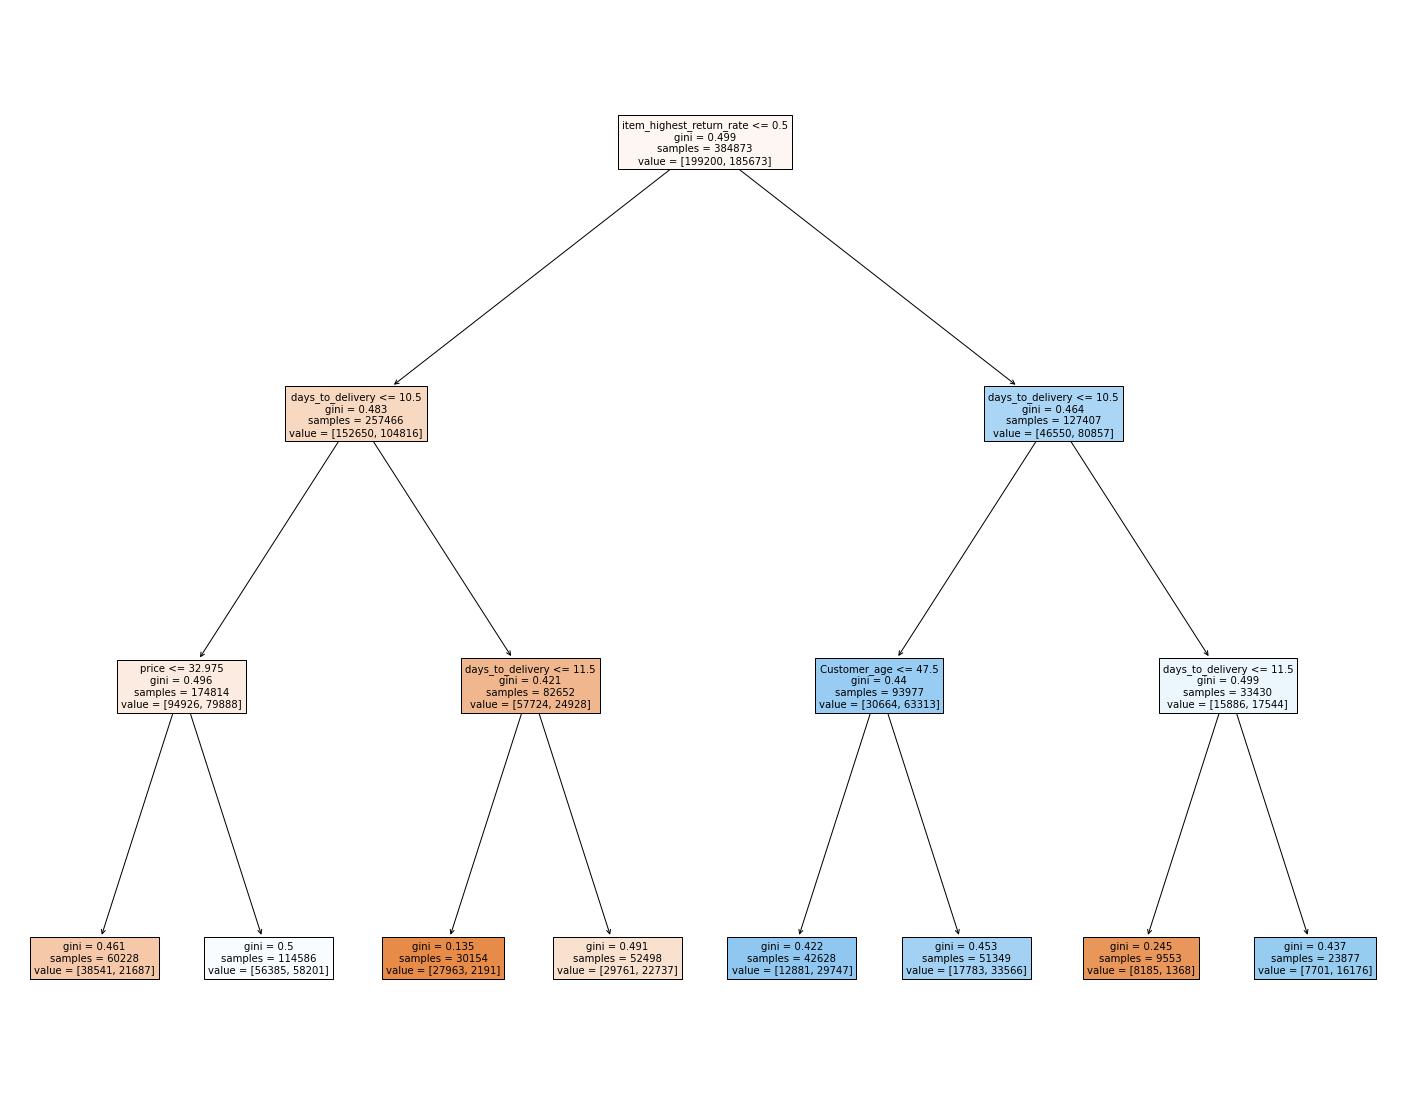

In [42]:
X = train.drop(['returnShipment', 'orderItemID', 'orderDate', 'deliveryDate', 'itemID', 'color', 'manufacturerID', 
               'customerID', 'salutation', 'dateOfBirth', 'state', 'creationDate', 'size'], axis = 1)
Y = train['returnShipment']

X = X.dropna()
Y = Y.dropna()

# Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

# Building the decision tree on train data-frame
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X_train, Y_train)

# Visualizing the decision-tree model
fig = plt.figure(figsize = (25,20))
plot_tree(tree_md, feature_names = X.columns, filled = True)

In [43]:
"""
To the Left = Yes = <=
To the Right = No = >

value = [0: No return , 1: return]
"""

'\nTo the Left = Yes = <=\nTo the Right = No = >\n\nvalue = [0: No return , 1: return]\n'

In [44]:
X.columns

Index(['price', 'days_to_delivery', 'Customer_age',
       'manufacturer_highest_return_rate', 'item_highest_return_rate',
       'feature_100', 'size_highest_return_rate', 'clothes',
       'state_highest_return_rate', 'salutation_highest_return_rate',
       'Item_Average_Price', 'price_higher_average', 'Company', 'Family', 'Mr',
       'Mrs', 'not reported', 'salutation_numb', 'feature_1', 'feature_2',
       'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7',
       'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18'],
      dtype='object')

In [45]:
## Creating interactions/features from the decision tree
## train
# interaction 1
train['interaction_1'] = np.where((train['item_highest_return_rate'] <= 0.5) & 
                                     (train['days_to_delivery'] > 10.5) & 
                                     (train['days_to_delivery'] <= 11.5), 1, 0)

# interaction 2
train['interaction_2'] = np.where((train['item_highest_return_rate'] <= 0.5) & 
                                     (train['days_to_delivery'] <= 10.5) & 
                                     (train['price'] <= 29.425), 1, 0)

# interaction 3
train['interaction_3'] = np.where((train['item_highest_return_rate'] > 0.5) & 
                                     (train['days_to_delivery'] <= 10.5), 1, 0)

# interaction 4
train['interaction_4'] = np.where((train['item_highest_return_rate'] > 0.5) & 
                                     (train['days_to_delivery'] > 11.5), 1, 0)
train.head()

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,interaction_1,interaction_2,interaction_3,interaction_4
0,1,2012-04-01,2012-04-03,186,m,denim,25,69.90,794,Mrs,...,0,0,0,0,0,0,0,0,1,0
1,2,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,Mrs,...,0,0,0,0,0,0,0,0,1,0
2,3,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,Mrs,...,0,0,0,0,0,0,0,0,1,0
3,4,2012-04-02,NaT,22,m,green,14,39.90,808,Mrs,...,0,0,0,0,0,0,1,0,0,0
4,5,2012-04-02,1990-12-31,151,39,black,53,29.90,825,Mrs,...,1,0,0,0,0,0,0,0,0,0


In [46]:
## Creating interactions/features from the decision tree
## test
# interaction 1
test['interaction_1'] = np.where((test['item_highest_return_rate'] <= 0.5) & 
                                     (test['days_to_delivery'] > 10.5) & 
                                     (test['days_to_delivery'] <= 11.5), 1, 0)

# interaction 2
test['interaction_2'] = np.where((test['item_highest_return_rate'] <= 0.5) & 
                                     (test['days_to_delivery'] <= 10.5) & 
                                     (test['price'] <= 29.425), 1, 0)

# interaction 3
test['interaction_3'] = np.where((test['item_highest_return_rate'] > 0.5) & 
                                     (test['days_to_delivery'] <= 10.5), 1, 0)

# interaction 4
test['interaction_4'] = np.where((test['item_highest_return_rate'] > 0.5) & 
                                     (test['days_to_delivery'] > 11.5), 1, 0)
test.head()

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,interaction_1,interaction_2,interaction_3,interaction_4
0,1,2013-04-01,2013-04-03,2347,43,magenta,1,89.9,12489,Mrs,...,0,0,0,0,0,0,0,0,0,0
1,2,2013-04-01,2013-04-03,2741,43,grey,1,99.9,12489,Mrs,...,0,0,0,0,0,0,0,0,1,0
2,3,2013-04-01,2013-04-03,2514,9,ecru,19,79.9,12489,Mrs,...,0,0,0,0,0,0,0,0,1,0
3,4,2013-04-01,2013-05-06,2347,42,brown,1,89.9,12489,Mrs,...,0,0,0,0,0,0,0,0,0,0
4,5,2013-04-01,NaT,2690,43,grey,1,119.9,12489,Mrs,...,0,0,0,0,0,0,0,0,0,0


In [47]:
train.shape

(481092, 53)

In [48]:
test.shape

(50078, 52)

In [49]:
train.to_csv('train_dataset_1.csv', index = False)
test.to_csv('test_dataset_1.csv', index = False)